In [23]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import arviz as az
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt
import scipy.stats as st
import astropy.units as u
import xarray as xr

from momenta.io import GW, NuDetector, Parameters
from momenta.io.neutrinos import BackgroundGaussian, BackgroundFixed
import momenta.utils.conversions
import momenta.analysis.limits as limits

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

def upperlimit_from_sample(sample: np.ndarray, CL: float = 0.90):
    x = np.array(sample).flatten()
    return np.percentile(x, 100*CL)

%matplotlib inline

In [74]:
def get_model(detector, gw, parameters):
    npix = hp.nside2npix(parameters.nside)
    toysgw = gw.prepare_toys("ra", "dec", "luminosity_distance", "radiated_energy", "theta_jn", nside=parameters.nside)
    toysgw = np.array([[toy.ipix, toy.luminosity_distance, toy.radiated_energy, toy.theta_jn] for toy in toysgw])
    coords = {
        "gw_toys": np.arange(len(toysgw)),
        "gw_pars": ["ipix", "luminosity_distance", "radiated_energy", "theta_jn"],
        "pix": np.arange(npix),
        "nusample": [s.name for s in detector.samples]
    }
    with pm.Model(coords=coords) as model:
        gw = pm.ConstantData("gw", toysgw, dims=("gw_toys", "gw_pars"))
        acc_map = pm.ConstantData('acceptance_map', [s.acceptances[parameters.spectrum].map for s in detector.samples], dims=("nusample", "pix")) 
        bkg = []
        for s in detector.samples:
            if not parameters.apply_det_systematics or isinstance(s.background, BackgroundFixed):
                bkg.append(pm.ConstantData(f"bkg_{s.name}", s.background.nominal))
            elif isinstance(s.background, BackgroundGaussian):
                bkg.append(pm.TruncatedNormal(f"bkg_{s.name}", mu=s.background.b0, sigma=s.background.error_b, lower=0))
        if not parameters.apply_det_systematics:
            xacc = 1
        else:
            xacc = pm.MvNormal("xacc", mu=np.ones(detector.nsamples), cov=detector.error_acceptance, dims="nusample")
        itoygw = pm.Categorical("itoygw", p=np.ones(len(toysgw))/len(toysgw))
        phi = pm.Uniform("phi", 1, 1e10)
        ipix = pm.Deterministic("ipix", gw[itoygw][0]).astype("int64")
        eiso = pm.Deterministic("eiso", phi / momenta.utils.conversions.eiso_to_phi(parameters.range_energy_integration, parameters.spectrum, gw[itoygw][1]))
        etot = pm.Deterministic("etot", eiso / momenta.utils.conversions.etot_to_eiso(gw[itoygw][3], parameters.jet))
        fnu = pm.Deterministic("fnu", etot / momenta.utils.conversions.fnu_to_etot(gw[itoygw][2]))
        sig = pm.Deterministic("sig", phi / 6 * xacc * acc_map[:,ipix], dims="nusample")
        # pot = pm.Potential("prior_jeffrey", -0.5 * pm.math.sum(pm.math.log(bkg+sig)))
        obs = pm.Poisson("obs", mu=bkg+sig, observed=[s.nobserved for s in detector.samples], dims="nusample")
    return model

In [32]:
parameters = Parameters("../examples/input_files/config.yaml")
parameters.set_models("x**-2", momenta.utils.conversions.JetIsotropic())
parameters.nside = 8
gw = GW(
        "GW190412", 
        "../examples/input_files/gw_catalogs/GW190412/GW190412_PublicationSamples.fits", 
        "../examples/input_files/gw_catalogs/GW190412/GW190412_subset.h5"
)
gw.set_parameters(parameters)

[2024-05-17 16:01:11,129:momenta:INFO] [GW] Fits is loaded from the file GW190412_PublicationSamples.fits
[2024-05-17 16:01:11,130:momenta:INFO] [GW] Samples are loaded from the file GW190412_subset.h5


In [4]:
antares = NuDetector("../examples/input_files/detector_antares.yaml")

# defining average acceptances for ANTARES (per half-sky)
ra, dec = hp.pix2ang(parameters.nside, np.arange(hp.nside2npix(parameters.nside)), lonlat=True)
alt, _ = antares.radec_to_altaz(ra*u.deg, dec*u.deg, gw.jd)
upgoing, downgoing = alt <= 0, alt > 0
# upgoing samples (acc=0 for downgoing sky)
acceptance_antares_uptracks = np.zeros(hp.nside2npix(parameters.nside))
acceptance_antares_uptracks[upgoing] = 2
acceptance_antares_upshowers = np.zeros(hp.nside2npix(parameters.nside))
acceptance_antares_upshowers[upgoing] = 1
# downoing samples (acc=0 for upgoing sky)
acceptance_antares_downtracks = np.zeros(hp.nside2npix(parameters.nside))
acceptance_antares_downtracks[downgoing] = 0.5
acceptance_antares_downshowers = np.zeros(hp.nside2npix(parameters.nside))
acceptance_antares_downshowers[downgoing] = 0.4

antares.set_acceptances([acceptance_antares_uptracks, acceptance_antares_downtracks, acceptance_antares_upshowers, acceptance_antares_downshowers],
                        "x**-2", nside=parameters.nside)
bkg_antares = [BackgroundGaussian(b, 0.20 * b) for b in [2.7e-3]*4]
nobs_antares = [0]*4
antares.set_observations(nobs_antares, bkg_antares)

[2024-05-17 15:12:29,030:momenta:INFO] [NuDetector] Object is loaded from the file ../examples/input_files/detector_antares.yaml.


In [83]:
det = NuDetector({
    "name": "Detector",
    "nsamples": 1,
    "samples": {
        "names": ["Sample"],
        "shortnames": ["s"],
        "energyrange": [0.1, 1e5],
    },
})
det.set_acceptances([np.ones(hp.nside2npix(parameters.nside))], "x**-2", nside=parameters.nside)
det.set_observations([0], [BackgroundFixed(107)])

[2024-05-17 17:24:14,667:momenta:INFO] [NuDetector] Object is loaded from a dictionary object.


/home/lamoureuxm/anaconda3/envs/stats/lib/python3.11/site-packages/pytensor/misc/safe_asarray.py:35: RuntimeWarning: overflow encountered in cast
  rval = np.asarray(a, order=order).astype(dtype)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CategoricalGibbsMetropolis: [itoygw]
>NUTS: [phi]


Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 3 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


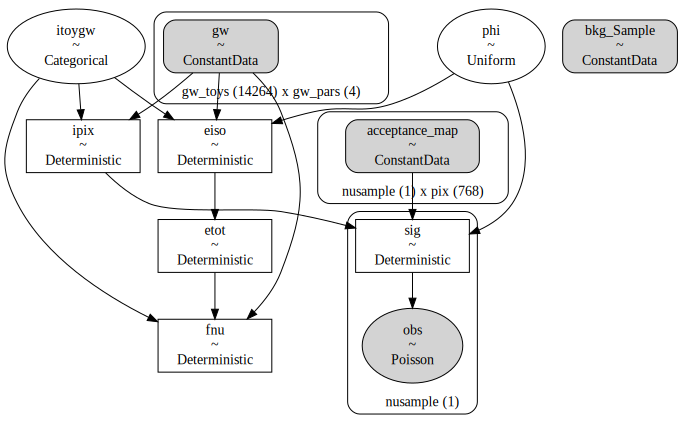

In [84]:
model = get_model(det, gw, parameters)
with model:
    idata = pm.sample(draws=4000, chains=4)
pm.model_to_graphviz(model)

Sampling: [itoygw, obs, phi]


(array([6.00389734e-10, 5.88381939e-10, 5.88381939e-10, 6.12397528e-10,
        7.08459886e-10, 7.20467680e-10, 5.28342966e-10, 5.88381939e-10,
        4.80311787e-10, 5.88381939e-10]),
 array([6.96214000e+05, 1.67254692e+08, 3.33813169e+08, 5.00371647e+08,
        6.66930124e+08, 8.33488602e+08, 1.00004708e+09, 1.16660556e+09,
        1.33316403e+09, 1.49972251e+09, 1.66628099e+09]),
 <BarContainer object of 10 artists>)

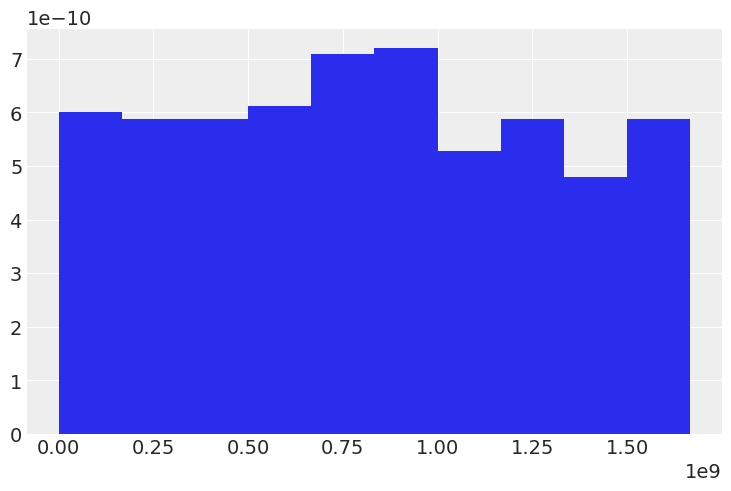

In [76]:
with model:
    prior_predictive = pm.sample_prior_predictive().prior_predictive
plt.hist(prior_predictive["obs"].values.flatten(), density=True)

Sampling: [obs]


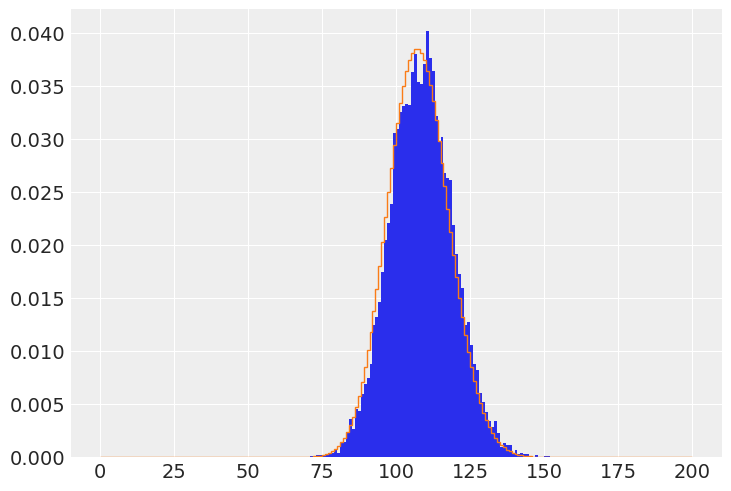

In [85]:
with model:
    posterior_predictive = pm.sample_posterior_predictive(trace=idata).posterior_predictive
bins = np.arange(0, 200+1)
plt.hist(posterior_predictive["obs"].values.flatten(), density=True, bins=bins)
plt.stairs(st.poisson.pmf(bins[:-1], det.samples[0].background.nominal), bins)

array([[<Axes: title={'center': 'phi'}>, <Axes: title={'center': 'phi'}>]],
      dtype=object)

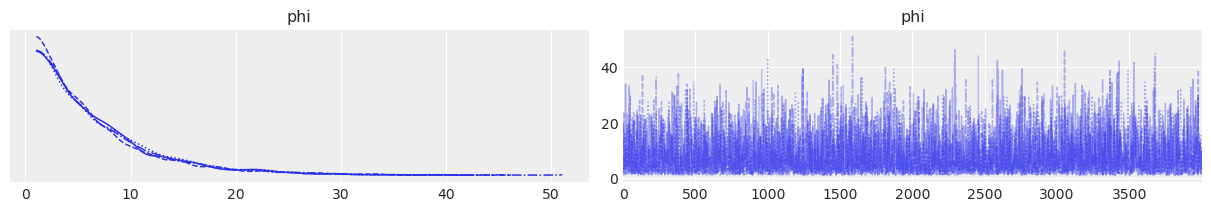

In [86]:
az.plot_trace(idata.posterior.phi)

In [40]:
limit_mcmc = upperlimit_from_sample(idata.posterior.phi[:,:], 0.90)
parameters.prior_signal = "jeffrey"
limit_momenta = limits.get_limit_flux(det, gw, parameters)
print(f"FLUX: Limit(MCMC) = {limit_mcmc} ; Limit(JANG) = {limit_momenta}")

# limit_mcmc = upperlimit_from_sample(idata.posterior.etot[:,:], 0.90)
# limit_momenta = limits.get_limit_etot(det, gw, parameters)
# print(f"ETOT: Limit(MCMC) = {limit_mcmc} ; Limit(JANG) = {limit_momenta}")

# limit_mcmc = upperlimit_from_sample(idata.posterior.fnu[:,:], 0.90)
# limit_momenta = limits.get_limit_fnu(det, gw, parameters)
# print(f"FNU: Limit(MCMC) = {limit_mcmc} ; Limit(JANG) = {limit_momenta}")

[2024-05-17 16:08:15,662:momenta:INFO] [Limits] GW190412, Detector, x**-2, limit(Flux) = 1.072e+01


FLUX: Limit(MCMC) = 10.847496956003155 ; Limit(JANG) = 10.715939731018764


In [46]:
type(model)

pymc.model.core.Model